# Fine-tuning ViLT For binary visual question answering (VQA)

![ViLT architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/vilt_architecture.jpg)

* Paper: https://arxiv.org/abs/2102.03334
* ViLT docs: https://huggingface.co/docs/transformers/master/en/model_doc/vilt

## Set-up environment: Imports and Configurations

### Import libraries

In [5]:
# !pip install wandb

In [60]:
# !pip install -q git+https://github.com/huggingface/transformers.git

In [61]:
# !pip install -q evaluate rouge_score

In [ ]:
# !pip install plotly

In [186]:
import os
import warnings
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import evaluate
import requests
import random

from copy import deepcopy
from tqdm import tqdm
from torchvision.io import read_image
from torch.utils.data import DataLoader
from transformers import ViltConfig, ViltProcessor, ViltForQuestionAnswering, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
from PIL import Image

In [315]:
os.environ["WANDB_PROJECT"]="vqa_binary_research"
SEED = 1234
OVERWRITE_OUTPUT_DIR = True
EVALUATION_STRATEGY = 'steps'
EVAL_STEPS = 500
LOGGING_STRATEGY = 'steps'
LOGGING_STEPS = 250
SAVE_STRATEGY = 'steps'
SAVE_STEPS = 500
SAVE_TOTAL_LIMIT = 2
LEARNING_RATE = 5e-5
BATCH_SIZE = 8
NUM_TRAIN_EPOCHS = 10.0
LOAD_BEST_MODEL_AT_END = True
REPORT_TO = 'wandb'
RUN_NAME = 'vilt_vqa_model'
EARLY_STOPPING_PATIENCE = 3

In [316]:
DATA_PATH = '/home/jovyan/ars/vqa-research/VQA/data/'
ANNOTATIONS_PATH = DATA_PATH + 'abstract_v002_train2017_annotations.json'
QUESTIONS_PATH = DATA_PATH + 'OpenEnded_abstract_v002_train2017_questions.json'
VQA_TRAIN_PATH = DATA_PATH + 'VQA_train.csv'
IMAGE_DIR = DATA_PATH + 'scene_img_abstract_v002_train2017/'
IMAGE_PREFIX = 'abstract_v002_train2015_'
IMAGE_FORMAT = '.png'
VILT_MODEL_PRETRAIN = 'dandelin/vilt-b32-finetuned-vqa' # get model from HF vilt-32b
MODELS_DIR = '/home/jovyan/ars/vqa-research/VQA/VILT_model/model_vilt_checkpoints'

In [317]:
warnings.filterwarnings('ignore')
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [318]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Load config, processor and model

I load the ViLT model, fine-tuned on VQAv2, from the [hub](https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).

In [191]:
processor = ViltProcessor.from_pretrained(VILT_B32_PRETRAINED)
config = ViltConfig.from_pretrained(VILT_B32_PRETRAINED)
model = ViltForQuestionAnswering.from_pretrained(VILT_B32_PRETRAINED, id2label=vilt_config.id2label, label2id=vilt_config.label2id)
model.to(device)

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0): ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_f

## EDA with binary VQA dataset 

In [192]:
dataset = pd.read_csv(VQA_TRAIN_PATH, index_col=0)
dataset.sample(5)

,image_id,question,question_id,answer
10990,212,Is there an odd number of ducks around the pond?,2122,yes
6148,11865,Are they twin sisters?,118652,yes
2645,900181662,Are the cat and mouse playing?,900181662,no
2255,900127211,Are all the dogs on the floor?,900127211,yes
11521,900087351,Is there more than one dog?,900087351,yes


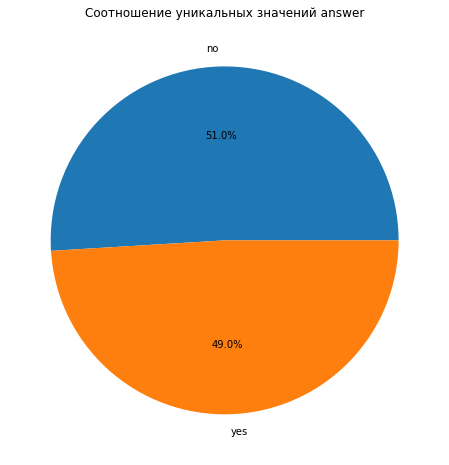

In [193]:
plt.figure(figsize=(8, 8))
dataset['answer'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Соотношение уникальных значений answer')
plt.ylabel('')
plt.show()

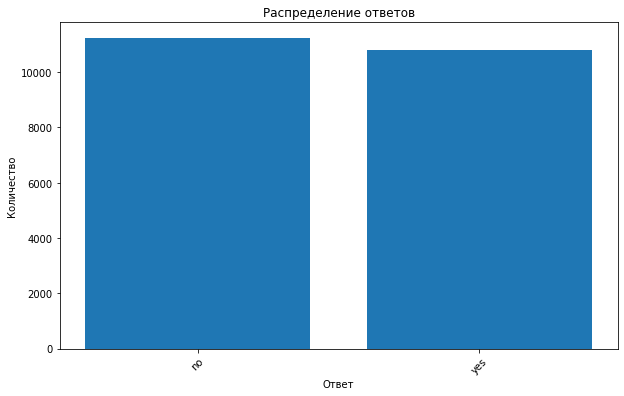

In [194]:
answer_counts = dataset['answer'].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.bar(answer_counts.index, answer_counts.values)
plt.xlabel('Ответ')
plt.ylabel('Количество')
plt.title('Распределение ответов')
plt.xticks(rotation=45)
plt.show()

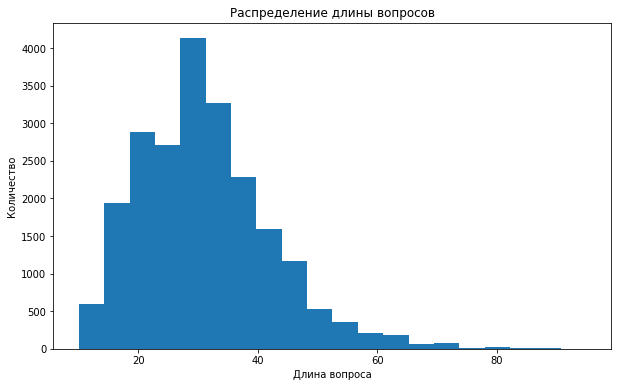

In [195]:
question_lengths = dataset['question'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(question_lengths, bins=20)
plt.xlabel('Длина вопроса')
plt.ylabel('Количество')
plt.title('Распределение длины вопросов')
plt.show()

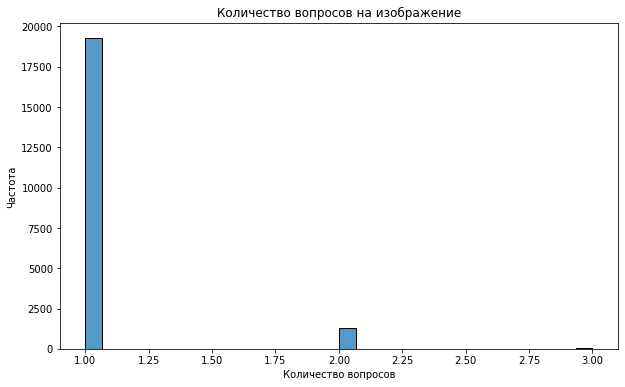

In [196]:
questions_per_image = dataset.groupby('image_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(questions_per_image, bins=30)
plt.title('Количество вопросов на изображение')
plt.xlabel('Количество вопросов')
plt.ylabel('Частота')
plt.show()

In [197]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22055 entries, 0 to 22054
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_id     22055 non-null  int64 
 1   question     22055 non-null  object
 2   question_id  22055 non-null  int64 
 3   answer       22055 non-null  object
dtypes: int64(2), object(2)
memory usage: 861.5+ KB


In [198]:
dataset.describe()

,image_id,question_id
count,2.205500e+04,2.205500e+04
mean,4.201610e+08,4.202090e+08
std,4.490614e+08,4.490164e+08
min,4.000000e+00,4.200000e+01
25%,9.392500e+03,9.392650e+04
50%,1.876000e+04,1.876000e+05
75%,9.000935e+08,9.000935e+08
max,9.002000e+08,9.002000e+08


In [199]:
print(f'Count unique images in dataset: {dataset["image_id"].nunique()}')
print(f'Count unique text_questions in dataset: {dataset["question"].nunique()}')
print(f'Count unique id_questions in dataset: {dataset["question_id"].nunique()}')

Count unique images in dataset: 20629
Count unique text_questions in dataset: 9471
Count unique id_questions in dataset: 22055


In [200]:
dataset["answer"].value_counts()

no     11240
yes    10815
Name: answer, dtype: int64

### Annotations

The example contains several answers (collected by different human annotators). The answer to a question can be a bit subjective: for instance for the question "Is there room on the table for anything else?", some people annotated this with "YES", others with "MAYBE". So there's a bit of disambiguity among the annotators

In [201]:
with open(ANNOTATIONS_PATH) as f:
    annotations = json.load(f)['annotations']

In [202]:
annotations[6]

{'question_type': 'is there',
 'multiple_choice_answer': 'yes',
 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 2},
  {'answer': 'yeah', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 6},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 8},
  {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'no', 'answer_confidence': 'maybe', 'answer_id': 10}],
 'image_id': 15675,
 'answer_type': 'yes/no',
 'question_id': 156750}

### Questions

In [203]:
with open(QUESTIONS_PATH) as f:
    questions = json.load(f)['questions']

In [204]:
print("Number of questions:", len(questions))

Number of questions: 22055


In [205]:
questions[6]

{'image_id': 15675,
 'question': 'Is there room on the table for anything else?',
 'question_id': 156750}

### Images

In [206]:
def show_img(dataset, img_dir, img_name, img_id):
    img = mpimg.imread(os.path.join(img_dir, img_name))
    question = dataset.loc[dataset['image_id'] == img_id].question.values[0]
    answer = dataset.loc[dataset['image_id'] == img_id].answer.values[0]

    plt.title(f'{question} - {answer}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

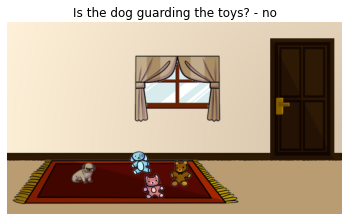

In [207]:
show_img(dataset, IMAGE_DIR, 'abstract_v002_train2015_000000000129.png', 129)

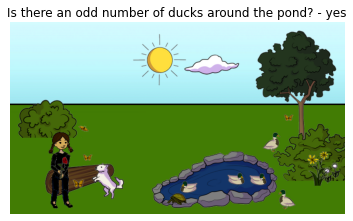

In [208]:
show_img(dataset, IMAGE_DIR, 'abstract_v002_train2015_000000000212.png', 212)

## Preprocess data

In [209]:
# lemmatize and lowercase with questions and answers
dataset[['question', 'answer']].apply(lambda x: x.str.lower(), axis=0)

,question,answer
0,is the boy having wine?,yes
1,is the boy having wine?,no
2,is it night time?,no
3,is it night time?,yes
4,is the boy hanging from monkey bars?,yes
...,...,...
22050,are the people afraid of the animals?,yes
22051,do the curtains match?,yes
22052,do the curtains match?,no
22053,does the woman look deep in thought?,yes


In [210]:
# we should fix image paths for correct version
dataset['image_path'] = IMAGE_PREFIX + (12 - dataset['image_id'].astype('str').str.len()).apply(lambda x: x * '0') + dataset['image_id'].astype('str') + IMAGE_FORMAT

In [211]:
dataset.sample(5)

,image_id,question,question_id,answer,image_path
6016,900186552,Is the dog having fun with the girl?,900186552,no,abstract_v002_train2015_000900186552.png
12783,900113442,Are the deer running?,900113442,yes,abstract_v002_train2015_000900113442.png
4057,16591,Is it raining?,165911,no,abstract_v002_train2015_000000016591.png
6202,900097750,Are the shelves the same height?,900097750,yes,abstract_v002_train2015_000900097750.png
5875,3393,Does the woman have a remote control in her hand?,33931,no,abstract_v002_train2015_000000003393.png


### Add Labels and Scores

We have multi-label classification problem (as multiple answers are possibly valid). Moreover, rather than just creating a one-hot encoded vector, one creates a soft encoding, based on the number of times a certain answer appeared in the annotations.

For instance, in the example above, the answer "YES" seems to be selected way more often than "MAYBE". Hence, we want the model to give more emphasis on "yes" then on "maybe". We can achieve this by giving a score of 1.0 to labels which are counted at least 3 times, and a score < 1.0 for labels that are counted less.

We'll add 2 keys to each annotations:
* labels, which is a list of integer indices of the labels that apply to a given image + question.
* scores, which are the corresponding scores (between 0 and 1), which indicate the importance of each label.

As we'll need the id2label mapping from the VQA dataset, we load it from the hub as follows:

In [212]:
def get_score(count):
    return min(1.0, count / 3)

In [313]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViLT/Fine_tuning_ViLT_for_VQA.ipynb
dataset['labels'] = np.nan
dataset['scores'] = np.nan

for annotation in tqdm(annotations):
    answers = annotation['answers']
    answer_count = {}

    for answer in answers:
        answer_count[answer['answer']] = answer_count.get(answer['answer'], 0) + 1

    labels = []
    scores = []

    for answer in answer_count:
        if answer not in list(config.label2id.keys()):
            continue
        labels.append(config.label2id[answer])
        score = get_score(answer_count[answer])
        scores.append(score)

        dataset.loc[dataset['question_id'] == annotation['question_id'], 'labels'] = dataset.loc[dataset['question_id'] == annotation['question_id'], 'labels'].apply(lambda x: labels)
        dataset.loc[dataset['question_id'] == annotation['question_id'], 'scores'] = dataset.loc[dataset['question_id'] == annotation['question_id'], 'scores'].apply(lambda x: scores)

100%|██████████| 22055/22055 [01:02<00:00, 350.13it/s]


In [314]:
dataset.head()

,image_id,question,question_id,answer,image_path,labels,scores
0,87,Is the boy having wine?,870,yes,abstract_v002_train2015_000000000087.png,"[9, 3]","[0.3333333333333333, 1.0]"
1,900000870,Is the boy having wine?,900000870,no,abstract_v002_train2015_000900000870.png,[9],[1.0]
2,14962,Is it night time?,149620,no,abstract_v002_train2015_000000014962.png,[9],[1.0]
3,900149620,Is it night time?,900149620,yes,abstract_v002_train2015_000900149620.png,[3],[1.0]
4,8277,Is the boy hanging from monkey bars?,82771,yes,abstract_v002_train2015_000000008277.png,[3],[1.0]


Next, I create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltImageProcessor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [216]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, config, processor, img_dir, max_length=32):
        self.data = data
        self.config = config
        self.processor = processor
        self.max_length = max_length
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.loc[idx, ['question', 'image_path', 'labels', 'scores']]
        img = read_image(self.img_dir + str(item['image_path']))[:3,:,:]
        encoding = self.processor(
            img,
            item['question'],
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
        )
        # remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()
            
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(self.config.id2label))
        for label, score in zip(item['labels'], item['scores']):
              targets[label] = score
        encoding['labels'] = targets
        
        return encoding

In [217]:
# 80 : 20 : 20
count_samples_train = int(np.round((dataset.shape[0] * 80 ) / 100))
count_samples_val = int((dataset.shape[0] - count_samples_train) / 2)
count_samples_test = int(dataset.shape[0] - count_samples_train - count_samples_val)

count_samples_train, count_samples_val, count_samples_test

(17644, 2205, 2206)

In [218]:
dataset_pytorch = VQADataset(dataset, config, processor, IMAGE_DIR)
train_df, val_df, test_df = torch.utils.data.random_split(dataset_pytorch, [count_samples_train, count_samples_val, count_samples_test])

## Initialize Trainer

In [219]:
args = TrainingArguments(
    output_dir=MODELS_DIR,
    overwrite_output_dir=OVERWRITE_OUTPUT_DIR,
    evaluation_strategy=EVALUATION_STRATEGY,
    eval_steps=EVAL_STEPS,
    logging_strategy=LOGGING_STRATEGY,
    logging_steps=LOGGING_STEPS,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=SAVE_TOTAL_LIMIT,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    report_to=REPORT_TO,
)

In [220]:
collator = DataCollatorWithPadding(processor.tokenizer)

trainer = Trainer(
    model,
    args,
    train_dataset=train_df,
    eval_dataset=val_df,
    data_collator=test_df,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)

In [ ]:
trainer.train()

## Evaluate model

In [267]:
finetunned_model = ViltForQuestionAnswering.from_pretrained(
    MODELS_DIR + "/checkpoint-9500",
    id2label=config.id2label,
    label2id=config.label2id 
).to(device)

processor = ViltProcessor.from_pretrained(VILT_B32_PRETRAINED)
collator = DataCollatorWithPadding(processor.tokenizer)

### Evaluating Test Dataset

In [243]:
def calc_metrics(model, processor, test_dl, metric, device):
    # count = 1
    for batch in tqdm(test_dl):
        batch = batch.to(device)
        labels = batch['labels']
        batch.pop('labels', None)

        outputs = model(**batch)
        logits = outputs.logits

        input_idxs = [logit.argmax(-1).item() for logit in logits]
        label_idxs = [label.argmax(-1).item()for label in labels]
        preds = [model.config.id2label[input_idx] for input_idx in input_idxs]
        refs = [model.config.id2label[label_idx] for label_idx in label_idxs]
        
        # print(preds)
        # print(refs)

        metric.add_batch(predictions=preds, references=refs)
        # if count == 2:
        #     break
        # count += 1

    return metric.compute()

In [244]:
rouge_metric = evaluate.load('rouge')

test_df_dataloader = DataLoader(
    test_df,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collator,
)

In [245]:
rouge_score = calc_metrics(finetunned_model, processor, test_df_dataloader, rouge_metric, device)
print(f'ROUGE: {rouge_score}')

100%|██████████| 276/276 [03:39<00:00,  1.26it/s]


ROUGE: {'rouge1': 0.8191296464188577, 'rouge2': 0.0, 'rougeL': 0.8186763372620127, 'rougeLsum': 0.8182230281051677}


## Inference model

In [319]:
def predict(model, processor, device, image, question):
    encoding = processor(image, question.lower(), return_tensors='pt').to(device)
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    return model.config.id2label[idx]

### Test model with random images

In [285]:
# first image
keks = "https://sun9-76.userapi.com/impg/NE5_oLRpH998CZr5ldSqHA1KNKQI5dg7t4PsrQ/yN01moa9Lp8.jpg?size=720x1280&quality=96&sign=25713ea41ef3d42004c31b7618c4d15c&type=album"
keks_image = Image.open(requests.get(keksiks, stream=True).raw)

# second image 
cat = "https://cs6.pikabu.ru/avatars/1625/x1625082-1039207390.png"
cat_image = Image.open(requests.get(cat, stream=True).raw)

# third image
city = "https://icms2.mydomlya.ru/upload/000/u1/2/3/moskva-photo-normal.jpg"
city_image = Image.open(requests.get(city, stream=True).raw)

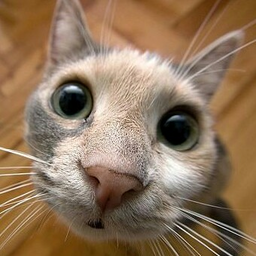

In [286]:
cat_image

In [276]:
print(predict(finetunned_model, processor, device, keks_image, 'are there dog faces here?'))
print(predict(finetunned_model, processor, device, keks_image, 'are there cupcakes here?'))

no
yes


In [290]:
print(predict(finetunned_model, processor, device, cat_image, 'is there dog here?'))
print(predict(finetunned_model, processor, device, cat_image, 'is there cat face here?'))

no
yes


In [282]:
print(predict(finetunned_model, processor, device, city_image, 'is there river here?'))
print(predict(finetunned_model, processor, device, city_image, 'is there buildings here?'))
print(predict(finetunned_model, processor, device, city_image, 'is there peoples here?'))

yes
yes
no


### Test model with images from dataset

In [298]:
dataset.sample(1)

,image_id,question,question_id,answer,image_path,labels,scores
7109,2883,Is the bookshelf empty?,28830,no,abstract_v002_train2015_000000002883.png,[9],[1.0]


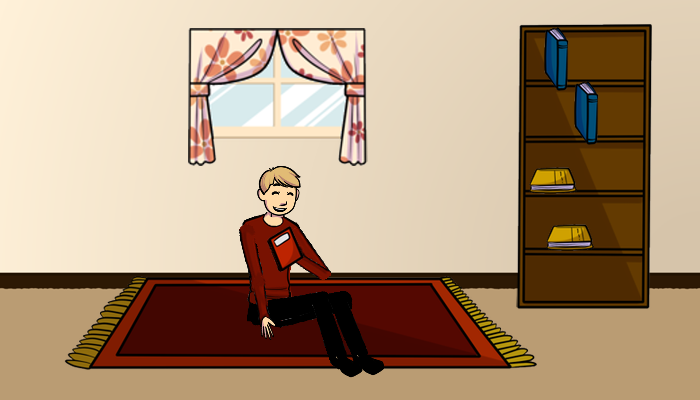

In [303]:
image_abstract = Image.open(IMAGE_DIR + 'abstract_v002_train2015_000000002883.png').convert('RGB')
image_abstract

In [312]:
print(predict(finetunned_model, processor, device, image_abstract, 'Is the person sitting?'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is the person reading the book?'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is there window here?'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is it night here?'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is it daytime here?'))
print(predict(finetunned_model, processor, device, image_abstract, 'Is the carpet color red here?'))

yes
no
yes
no
yes
yes
